In [1]:
%pylab inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10


import requests
import re
import datetime
import json
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt

def getOptionSet(table,option):
    return {x[option] for x in table}

def structureData(data, keys):
    if 0 == len(keys):
        return data
    return {opt: structureData([x for x in data if opt==x[keys[0]]],keys[1:]) for opt in getOptionSet(data,keys[0])}

def getNumber(x):
    if x is None:
        return 0
    tmp = re.search('[0-9]+', x)
    if tmp is None:
        return 0
    return int(tmp.group())

def filterByValue(data, key, val):
    return [x for x in data if x[key] == val]

def sortRiscCls(x):
    return {'AA': 0,'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'HR': 7, None: 8}[x]


class BarStacked:
    def __init__(self):
        self.barPlotList = []
        
    def addBarPlot(data):
        pass

def normalizeDataOffsets(data, offsets):
    return np.array(data) / offsets[-1], np.array(offsets) / offsets[-1]



def getCategories1D(data):
    categories = set({})
    for c in data.values():
        categories.update(c.keys())
    return categories

def getCategories2D(data):
    categories = set({})
    for co in data.values():
        categories.update(getCategories(co))
    return categories
        


def getCategories(data):
    categories = set({})
    for c in data.values():
        if type(c.values()[0]) is not dict:
            categories.update(c.keys())
        else:
            for x in c.values():
                categories.update(getCategories(x))
    return categories
    
def getPlotLists(data, catList, sortKey):
    dataItems = sorted(data.items(), key=sortKey)
    keys = [x[0] for x in dataItems]
    vals = [x[1] for x in dataItems]
    plotData = [[len(d[c]) if c in d else 0 for d in vals] for c in catList]
    plotOffsets = [np.zeros(len(plotData[0]))]
    for i, d in enumerate(plotData):
        plotOffsets.append(plotOffsets[i] + np.array(d))
    return keys, plotData, plotOffsets

def getPlotListsByKeys(data, catList, keyList):
    plotData = [[len(data[k][c]) if k in data and c in data[k] else 0 for k in keyList] for c in catList]
    plotOffsets = [np.zeros(len(plotData[0]))]
    for i, d in enumerate(plotData):
        plotOffsets.append(plotOffsets[i] + np.array(d))
    return {'keys': keyList, 'plotdata': plotData, 'plotoffsets': plotOffsets}

def reshapeList(d, l):
    q = len(d)/l
    return [d[x*q+y] for y in range(q) for x in range(l)]

def barStacked2D(data, xLabel='category', yLabel='rel', title='', sortLabels=getNumber, sortX=sortRiscCls, normalize=True):
    if 0 == len(data):
        print('empty dataset')
        return

    categories = getCategories2D(data)
    classes = getCategories1D(data)
    
    catList = sorted(list(categories), key=sortLabels)
    clsList = sorted(list(classes), key=sortX)

    N = 24
    ind = np.arange(N)    # the x locations for the groups
    ind = [x + x/3 for x in range(N)]
    width = 0.55       # the width of the bars: can also be len(x) sequence

    
    keysDict = {}
    plotDataDict = {}
    plotOffsetsDict = {}

    allPlotData = {k: getPlotListsByKeys(v,catList,clsList) for k, v in data.items()}

    if normalize is True:
        for k, v in allPlotData.items():
            allPlotData[k]['plotdata'], allPlotData[k]['plotoffsets'] = normalizeDataOffsets(v['plotdata'], v['plotoffsets'])

    
    plotData = []
    plotOffsets = []
    for k, v in allPlotData.items():
        for i, d in enumerate(v['plotdata']):
            if len(plotData) <= i:
                plotData.append([])
            if len(plotOffsets) <= i:
                plotOffsets.append([])
            plotData[i].extend(d)
            plotOffsets[i].extend(v['plotoffsets'][i])
        
        
        
    plotData = [reshapeList(x,3) for x in plotData]
    plotOffsets = [reshapeList(x,3) for x in plotOffsets]

    
    p = [plt.bar(ind, d, width, bottom=plotOffsets[i]) for i,d in enumerate(plotData)]

    
    keys = ["{} {}".format(k,c) for k, v in allPlotData.items() for c in v['keys']]
    
    keys = reshapeList(keys,3)

    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    plt.title(title)
    
    plt.xticks(ind, keys)
    plt.legend([x[0] for x in p], catList)

    plt.show()
    
def barStacked(data, xLabel='category', yLabel='rel', title='', sortLabels=getNumber, sortX=sortRiscCls, normalize=True):
    if 0 == len(data):
        print('empty dataset')
        return

    categories = getCategories(data)
    
    catList = sorted(list(categories), key=sortLabels)

    N = len(data.keys())
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    keys, plotData, plotOffsets = getPlotLists(data, catList, sortX)
        
    if normalize is True:
        plotData, plotOffsets = normalizeDataOffsets(plotData, plotOffsets)

   
    p = [plt.bar(ind, d, width, bottom=plotOffsets[i]) for i,d in enumerate(plotData)]

    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    plt.title(title)
    
    plt.xticks(ind, keys)
    plt.legend([x[0] for x in p], catList)

    plt.show()
    
def pieChart(dataDict):
    fig1, ax1 = plt.subplots()
    ax1.pie(dataDict.values(), labels=dataDict.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()  

payload = pickle.load(open('pubdatapayload_complete.pickle','rb'))
loansByYear = {y: [x for x in payload if '{}'.format(y) == x['FirstPaymentDate'][:4]] for y in range(2011,2020)}



Populating the interactive namespace from numpy and matplotlib


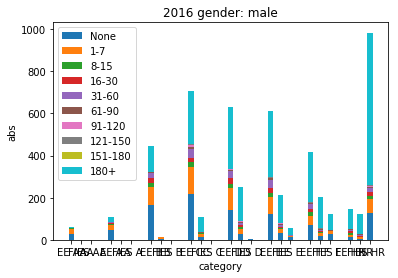

/home/stefan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in divide


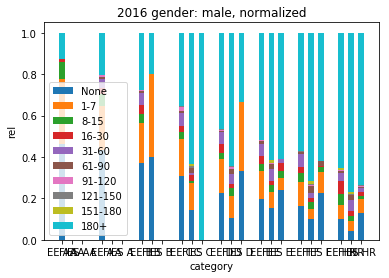

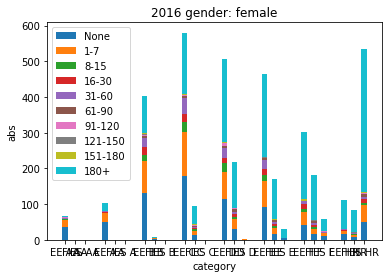

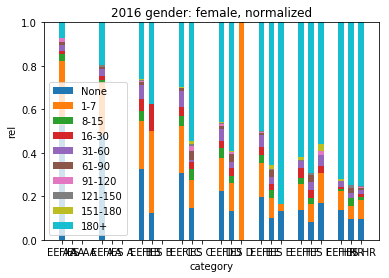

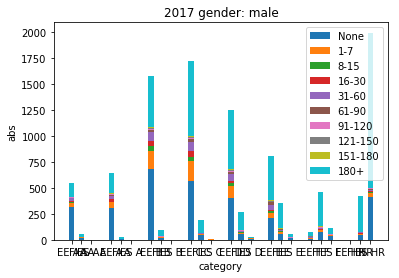

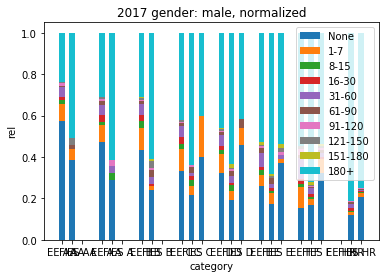

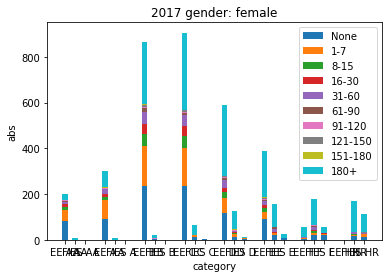

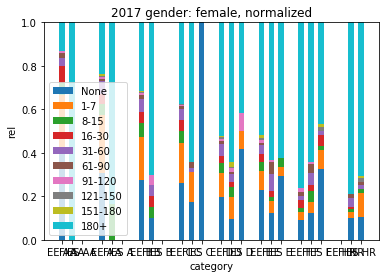

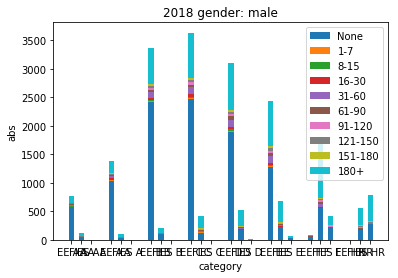

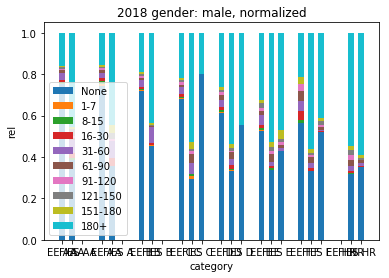

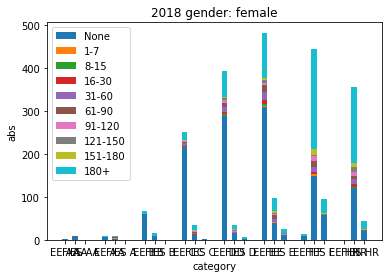

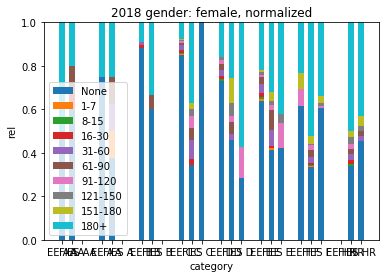

In [2]:
for year in range(2016,2019):
    for gender in [0, 1]:
        barStacked2D(structureData(filterByValue(loansByYear[year], 'Gender', gender), ['Country', 'Rating','WorseLateCategory']),title='{} gender: {}'.format(year, {0: 'male', 1: 'female', 2: 'unknown'}[gender]),yLabel='abs',normalize=False)
        barStacked2D(structureData(filterByValue(loansByYear[year], 'Gender', gender), ['Country', 'Rating','WorseLateCategory']),title='{} gender: {}, normalized'.format(year, {0: 'male', 1: 'female', 2: 'unknown'}[gender]))
        #barStacked(structureData(filterByValue(loansByYear[year], 'Gender', gender), ['Rating','WorseLateCategory']),title='{} gender: {}'.format(year, {0: 'male', 1: 'female', 2: 'unknown'}[gender]),yLabel='abs',normalize=False)
        #barStacked(structureData(filterByValue(loansByYear[year], 'Gender', gender), ['Rating','WorseLateCategory']),title='{} gender: {}, normalized'.format(year, {0: 'male', 1: 'female', 2: 'unknown'}[gender]))
